In [1]:
# Imports and GPU check
%matplotlib inline
import os
import random
import time
import pandas as pd
import seaborn as sns

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.init as init
import torchvision
import torchvision.transforms as transforms
from torch import nn, optim
from torch.utils.data import DataLoader, Subset
from torchvision import models
from tqdm import tqdm
from itertools import product

# Fix HTTPS certificate error
import ssl
ssl_create_default_https_context = ssl._create_unverified_context
from CustomImageDataset import CustomImageDataset


# Check for GPU availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")


Using device: cpu


In [2]:
def set_seed(seed=42):
    """Sets the seed for reproducibility."""
    # Python RNG
    random.seed(seed)
    
    # PyTorch RNGs
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
    
    # Numpy RNG
    np.random.seed(seed)
    
    # OS RNG
    os.environ['PYTHONHASHSEED'] = str(seed)

def worker_init_fn(worker_id):    
    """Ensure that the data loading process is deterministic."""
    np.random.seed(np.random.get_state()[1][0] + worker_id)
    
set_seed(42)  

In [3]:
base_path = "C:/Users/User/Desktop/Deep Learning/dataset_breast/IDC_regular_ps50_idx5"

# import data
folder = os.listdir("C:/Users/User/Desktop/Deep Learning/dataset_breast/IDC_regular_ps50_idx5")
print(len(folder))

279


Are they both neded


In [4]:
total_images = 0
for n in range(len(folder)):
    patient_id = folder[n]
    for c in [0, 1]:
        patient_path = base_path + "/" + patient_id 
        class_path = patient_path + "/" + str(c) + "/"
        subfiles = os.listdir(class_path)
        total_images += len(subfiles)

are they both needeed?

In [5]:
data = pd.DataFrame(index=np.arange(0, total_images), columns=["patient_id", "path", "target"])

k = 0
for n in range(len(folder)):
    patient_id = folder[n]
    patient_path = base_path + "/" + patient_id 
    for c in [0, 1]:
        class_path = patient_path + "/" + str(c) + "/"
        subfiles = os.listdir(class_path)
        for m in range(len(subfiles)):
            image_path = subfiles[m]
            data.loc[k, "path"] = class_path + image_path
            data.loc[k, "target"] = c
            data.loc[k, "patient_id"] = patient_id
            k += 1  

Exploratory analysis

C:\Users\User\AppData\Local\Temp\ipykernel_13232\2284845665.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="target", data=data, palette="Set2", ax=ax[2])


Text(0.5, 1.0, 'How many patches show IDC?')

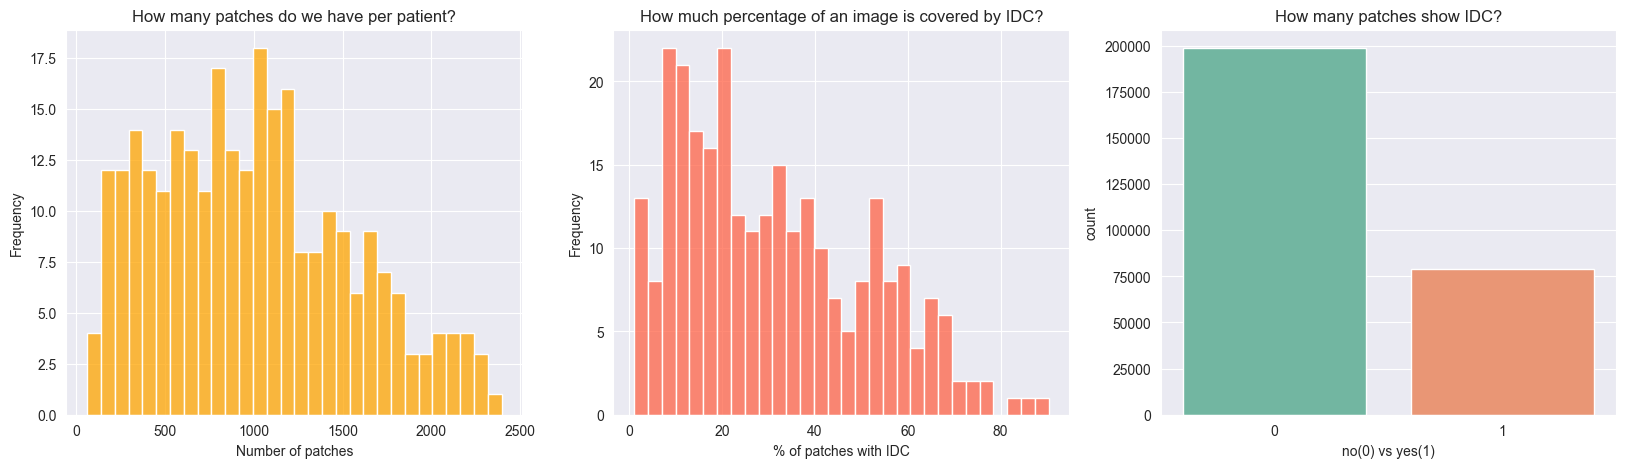

In [6]:

# Calculate the percentage of cancer per patient
cancer_perc = data.groupby("patient_id").target.value_counts() / data.groupby("patient_id").target.size()
cancer_perc = cancer_perc.unstack()

fig, ax = plt.subplots(1, 3, figsize=(20, 5))

# Use histplot instead of distplot
sns.histplot(data.groupby("patient_id").size(), ax=ax[0], color="Orange", kde=False, bins=30)
ax[0].set_xlabel("Number of patches")
ax[0].set_ylabel("Frequency")
ax[0].set_title("How many patches do we have per patient?")

# Use histplot for the percentage of patches with IDC
sns.histplot(cancer_perc.loc[:, 1] * 100, ax=ax[1], color="Tomato", kde=False, bins=30)
ax[1].set_title("How much percentage of an image is covered by IDC?")
ax[1].set_ylabel("Frequency")
ax[1].set_xlabel("% of patches with IDC")

# Adjust countplot according to new Seaborn updates
sns.countplot(x="target", data=data, palette="Set2", ax=ax[2])
ax[2].set_xlabel("no(0) vs yes(1)")
ax[2].set_title("How many patches show IDC?")

Hyperparameters

In [7]:

batch_size = 32
train_dataset_size = 500  # Reduced dataset size for quicker training
test_dataset_size = 200

epochs = 20
learning_rate = 0.001

Data Loading

In [8]:
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),# Example of an augmentation
    transforms.Resize((50, 50)),
    transforms.ToTensor() # Convert images to tensors
])


# Split the data into training and testing sets
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

full_test_dataset = CustomImageDataset(dataframe=test_data, transform=transform)
full_train_dataset = CustomImageDataset(dataframe=train_data, transform=transform)


# Reducing the training dataset size 
indices = list(range(train_dataset_size))
train_dataset = Subset(full_train_dataset, indices)

# Reducing the testing dataset size 
indices = list(range(test_dataset_size))
test_dataset = Subset(full_test_dataset, indices)

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)

print(f"Full train set size: {len(full_train_dataset)} - Reduced train set size: {len(train_dataset)} - Full test set size: {len(full_test_dataset)} - Reduced test size: {len(test_dataset)}")

Full train set size: 222019 - Reduced train set size: 500 - Full test set size: 55505 - Reduced test size: 200


In [9]:
from collections import Counter
# Assuming your CustomImageDataset class returns (image, label) tuples
labels = [label for _, label in test_dataset]

# Count the occurrences of each class
class_distribution = Counter(labels)
print("Class distribution in test dataset:", class_distribution)

Class distribution in test dataset: Counter({0: 146, 1: 54})


# Count class distribution
from collections import Counter
class_distribution = Counter(labels)
print(class_distribution)Normalisation

In [10]:
unique_sizes = set()

for i in range(len(train_loader)):
    image, _ = train_dataset[i]  # Get each image tensor (and ignore the label for this check)
    unique_sizes.add(image.size())  # Add the size of each tensor to the set

# Since sets only contain unique elements, you can check if all tensors are the same size:
if len(unique_sizes) == 1:
    print("All tensors are of the same size:", unique_sizes)
else:
    print("Found tensors of varying sizes:", unique_sizes)

All tensors are of the same size: {torch.Size([3, 50, 50])}


In [11]:
def calculate_mean_and_variance(loader):
    mean = 0.0
    variance = 0.0
    total_images = 0

    for images, _ in loader:
        # Rearrange batch to be the shape of [B, C, W * H]
        images = images.view(images.size(0), images.size(1), -1)
        # Update total_images
        total_images += images.size(0)
        # Compute mean and variance here
        mean += images.mean(2).sum(0) 
        variance += images.var(2).sum(0)

    # Final mean and variance
    mean /= total_images
    variance /= total_images 

    return mean, variance

# Assuming train_loader is defined and loaded
mean, variance = calculate_mean_and_variance(train_loader)
std = variance.sqrt()

print(f"Mean: {mean}")
print(f"Standard Deviation: {std}")

Mean: tensor([0.8121, 0.6298, 0.7295])
Standard Deviation: tensor([0.1009, 0.1586, 0.1188])


Input Visualisation

Label: 0


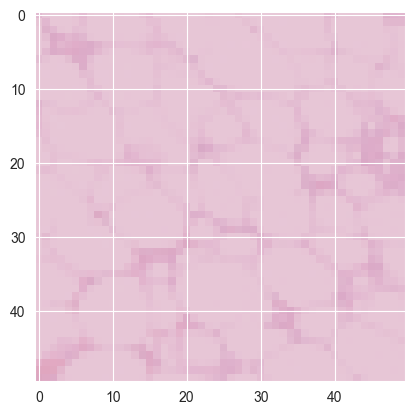

Label: 0


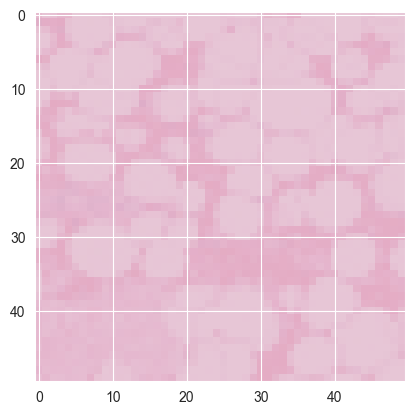

Label: 0


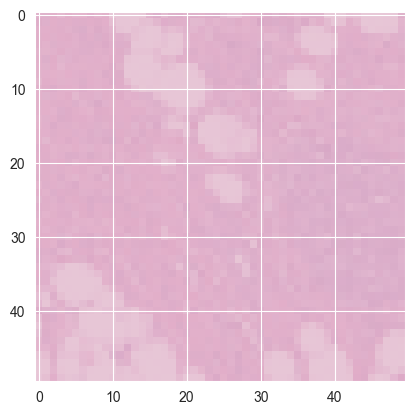

Label: 1


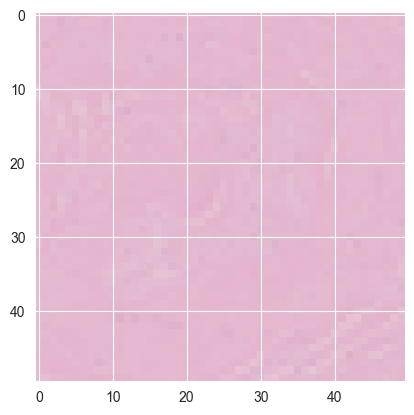

Label: 1


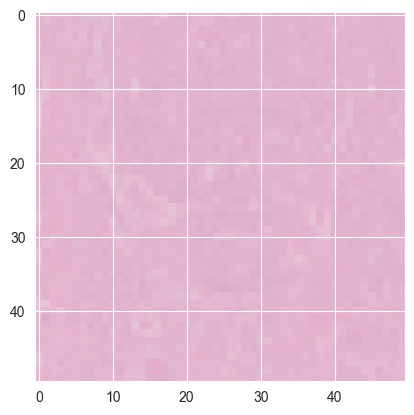

In [12]:
def denormalize(img, mean, std):
    """Denormalizes an image tensor using mean and std."""
    mean = torch.tensor(mean).reshape(-1, 1, 1) if not isinstance(mean, torch.Tensor) else mean.reshape(-1, 1, 1)
    std = torch.tensor(std).reshape(-1, 1, 1) if not isinstance(std, torch.Tensor) else std.reshape(-1, 1, 1)
    img = img * std + mean  # Denormalize
    return img

def imshow(img, mean, std):
    """Displays a tensor as an image after denormalizing."""
    img = denormalize(img, mean, std)  # Denormalize
    img = torch.clamp(img, 0, 1)  # Clamp to [0, 1] range
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))  # Convert from tensor image
    plt.show()

#mean = [0.8121, 0.6298, 0.7295]
#std = [0.1009, 0.1586, 0.1188]

# Example: Display images
num_images = 5
classes = ['0', '1']  # Adjust as per your classes

for i in range(num_images):
    image, label = test_dataset[i]  # Direct unpacking
    print('Label:', classes[label])
    imshow(image, mean, std)

Training & Validation

In [13]:
def train_and_validate(model, train_loader, test_loader, criterion, optimizer, epochs, device):
    train_losses = []
    train_accuracies = []
    validation_losses = []
    validation_accuracies = []
    
    start_time = time.time()
    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_loss, correct_train, total_train = 0, 0, 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()
        
        train_loss /= len(train_loader.dataset)
        train_accuracy = 100 * correct_train / total_train
        
        # Validation Phase
        model.eval()
        validation_loss, correct_val, total_val = 0, 0, 0
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                
                validation_loss += loss.item() * images.size(0)
                _, predicted = torch.max(outputs, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()
        
        validation_loss /= len(test_loader.dataset)
        validation_accuracy = 100 * correct_val / total_val
        
        # Store metrics
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        validation_losses.append(validation_loss)
        validation_accuracies.append(validation_accuracy)
        
        print(f'Epoch [{epoch+1}/{epochs}], Training Loss: {train_loss:.4f}, Training Accuracy: {train_accuracy:.2f}%, Validation Loss: {validation_loss:.4f}, Validation Accuracy: {validation_accuracy:.2f}%')
    
    end_time = time.time()
    execution_time = end_time - start_time
    minutes = int(execution_time // 60)
    seconds = int(execution_time % 60)
    print(f"\nExecution time: {minutes:02}:{seconds:02}")
    
    return train_losses, train_accuracies, validation_losses, validation_accuracies

Plot Metrics

In [14]:

def plot_metrics(train_losses, train_accuracies, validation_losses, validation_accuracies):
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.plot(validation_losses, label='Validation Loss')
    plt.title('Training vs. Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Training Accuracy')
    plt.plot(validation_accuracies, label='Validation Accuracy')
    plt.title('Training vs. Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

Model DNN (4 layers)

In [15]:
# DNN Model: 4 linear layers
class DNN(nn.Module):
    def __init__(self):
        super(DNN, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(3*50*50, 512), 
            nn.ReLU(),# The weight matrix has dimensions [512, 3*50*50]
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 2) # output layer
            
        )

        # Initialize weights using He initialization explicitly
        for layer in self.modules():
            # Applies He initialization to each linear layer
            if isinstance(layer, nn.Linear):
                init.kaiming_normal_(layer.weight, mode='fan_out', nonlinearity='relu')
                
                # Initialize biases to zero
                if layer.bias is not None:
                    init.constant_(layer.bias, 0)

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

dnn_model = DNN().to(device) 
print(dnn_model)

DNN(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=7500, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=128, bias=True)
    (5): ReLU()
    (6): Linear(in_features=128, out_features=2, bias=True)
  )
)


Learning Rate & Loss Function

In [16]:
learning_rate = 0.01 # a common starting point

# Loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(dnn_model.parameters(), lr=learning_rate)

In [17]:
model = dnn_model

# Training and Validation Loop
for epoch in tqdm(range(epochs)):
    # Training Phase
    model.train()  # Set the model to training mode
    
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)  # Move data to the appropriate device
        
        optimizer.zero_grad()  # Zero the gradients to prevent accumulation
        outputs = model(images)  # Forward pass
        loss = loss_fn(outputs, labels)  # Calculate the loss
        loss.backward()  # Backward pass
        optimizer.step()  # Optimize the model

100%|██████████| 20/20 [00:18<00:00,  1.10it/s]


In [18]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [19]:
# the lower the loss the better model performance
for epoch in range(epochs):
    print(f"Epoch {epoch+1}\n-------------------------------")
    train_loop(train_loader, dnn_model, loss_fn, optimizer)
print("Done!")

Epoch 1
-------------------------------
loss: 0.470963  [    0/  500]
Epoch 2
-------------------------------
loss: 0.520609  [    0/  500]
Epoch 3
-------------------------------
loss: 0.664845  [    0/  500]
Epoch 4
-------------------------------
loss: 0.717235  [    0/  500]
Epoch 5
-------------------------------
loss: 0.535889  [    0/  500]
Epoch 6
-------------------------------
loss: 0.621161  [    0/  500]
Epoch 7
-------------------------------
loss: 0.569096  [    0/  500]
Epoch 8
-------------------------------
loss: 0.675603  [    0/  500]
Epoch 9
-------------------------------
loss: 0.644084  [    0/  500]
Epoch 10
-------------------------------
loss: 0.548895  [    0/  500]
Epoch 11
-------------------------------
loss: 0.559882  [    0/  500]
Epoch 12
-------------------------------
loss: 0.573782  [    0/  500]
Epoch 13
-------------------------------
loss: 0.514386  [    0/  500]
Epoch 14
-------------------------------
loss: 0.737797  [    0/  500]
Epoch 15
------

Running the model

Epoch [1/20], Training Loss: 0.6044, Training Accuracy: 70.80%, Validation Loss: 0.6215, Validation Accuracy: 71.00%
Epoch [2/20], Training Loss: 0.6049, Training Accuracy: 70.60%, Validation Loss: 0.6033, Validation Accuracy: 72.00%
Epoch [3/20], Training Loss: 0.6069, Training Accuracy: 70.40%, Validation Loss: 0.6085, Validation Accuracy: 71.00%
Epoch [4/20], Training Loss: 0.6078, Training Accuracy: 70.40%, Validation Loss: 0.6103, Validation Accuracy: 71.50%
Epoch [5/20], Training Loss: 0.6086, Training Accuracy: 70.40%, Validation Loss: 0.6028, Validation Accuracy: 72.50%
Epoch [6/20], Training Loss: 0.6045, Training Accuracy: 70.80%, Validation Loss: 0.6039, Validation Accuracy: 72.00%
Epoch [7/20], Training Loss: 0.6054, Training Accuracy: 70.60%, Validation Loss: 0.5946, Validation Accuracy: 71.50%
Epoch [8/20], Training Loss: 0.6051, Training Accuracy: 70.60%, Validation Loss: 0.6118, Validation Accuracy: 71.00%
Epoch [9/20], Training Loss: 0.6045, Training Accuracy: 70.60%, 

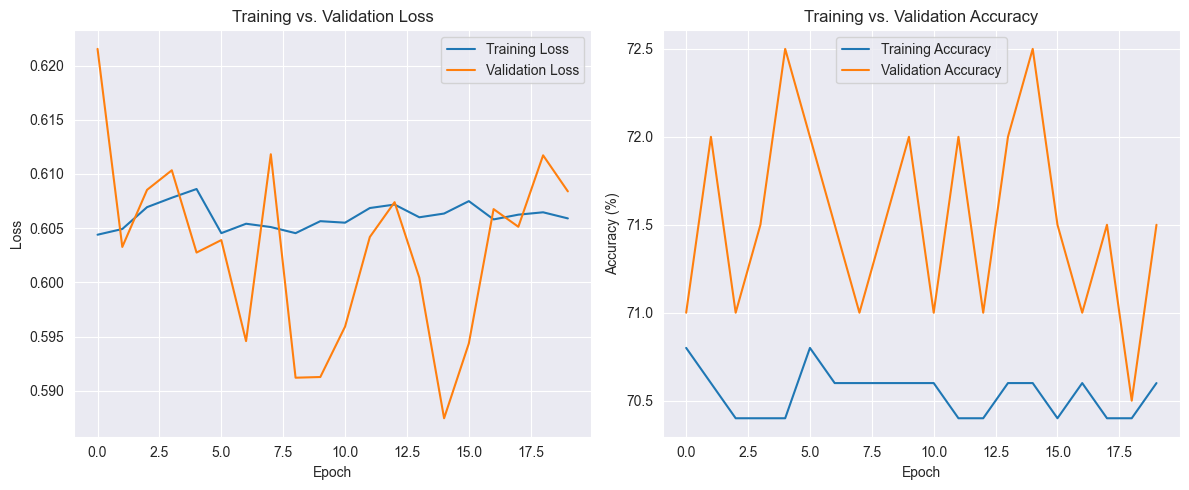

In [20]:
model_4dnn = dnn_model
optimizer = optim.SGD(model_4dnn.parameters(), lr=learning_rate)

train_losses, train_accuracies, validation_losses, validation_accuracies = train_and_validate(model_4dnn, train_loader, test_loader, loss_fn, optimizer, epochs, device)
plot_metrics(train_losses, train_accuracies, validation_losses, validation_accuracies)

DNN Model with Batch Normalization

In [21]:
# DNN Model with Batch Normalization
class DNN_BatchNorm(nn.Module):
    def __init__(self, dropout_rate=0.2):
        super(DNN_BatchNorm, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_stack = nn.Sequential(
            nn.Linear(7500, 1024),
            nn.BatchNorm1d(1024),  # Batch Normalization
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),   # Batch Normalization
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),   # Batch Normalization
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),   # Batch Normalization
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),    # Batch Normalization
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(64, 2)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_stack(x)
        return logits

dnn_batchnorm_model = DNN_BatchNorm().to(device)
print(dnn_batchnorm_model)

DNN_BatchNorm(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_stack): Sequential(
    (0): Linear(in_features=7500, out_features=1024, bias=True)
    (1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.2, inplace=False)
    (4): Linear(in_features=1024, out_features=512, bias=True)
    (5): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.2, inplace=False)
    (8): Linear(in_features=512, out_features=256, bias=True)
    (9): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): Dropout(p=0.2, inplace=False)
    (12): Linear(in_features=256, out_features=128, bias=True)
    (13): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): ReLU()
    (15): Dropout(p=0.2, inplace=False)
    (16): Linear(in_features=128, out_features=64, bias=True)
    (17):

Epoch [1/20], Training Loss: 0.5750, Training Accuracy: 71.20%, Validation Loss: 7.3854, Validation Accuracy: 72.50%
Epoch [2/20], Training Loss: 0.4707, Training Accuracy: 80.00%, Validation Loss: 0.6591, Validation Accuracy: 80.50%
Epoch [3/20], Training Loss: 0.4116, Training Accuracy: 81.60%, Validation Loss: 0.5501, Validation Accuracy: 79.00%
Epoch [4/20], Training Loss: 0.4452, Training Accuracy: 83.00%, Validation Loss: 0.4702, Validation Accuracy: 77.50%
Epoch [5/20], Training Loss: 0.4207, Training Accuracy: 84.60%, Validation Loss: 0.5050, Validation Accuracy: 75.00%
Epoch [6/20], Training Loss: 0.3985, Training Accuracy: 85.20%, Validation Loss: 0.5475, Validation Accuracy: 75.50%
Epoch [7/20], Training Loss: 0.3689, Training Accuracy: 86.60%, Validation Loss: 0.4877, Validation Accuracy: 77.50%
Epoch [8/20], Training Loss: 0.3214, Training Accuracy: 88.40%, Validation Loss: 0.9658, Validation Accuracy: 74.00%
Epoch [9/20], Training Loss: 0.3626, Training Accuracy: 88.40%, 

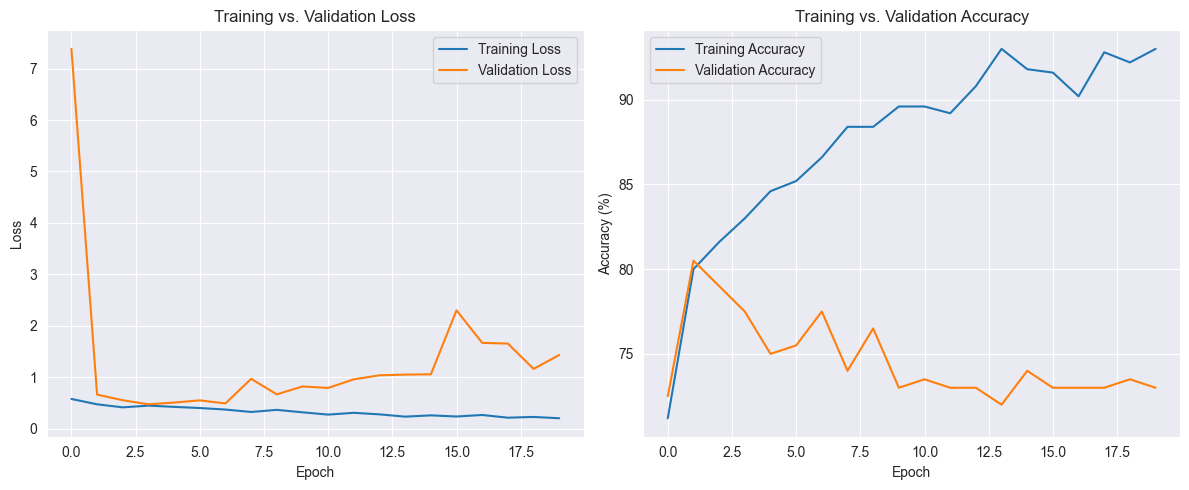

In [22]:
model = DNN_BatchNorm().to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate) # NO L2 regularization
criterion = nn.CrossEntropyLoss()

train_losses, train_accuracies, validation_losses, validation_accuracies = train_and_validate(model, train_loader, test_loader, criterion, optimizer, epochs, device)
plot_metrics(train_losses, train_accuracies, validation_losses, validation_accuracies)

Hyperparameter search

In [26]:
def train_validate_model(params, device):
    print(params)
    print()
    
    # Unpack parameters
    learning_rate = params['learning_rate']
    dropout_rate = params['dropout_rate']
    weight_decay = params['weight_decay']
    batch_size = params['batch_size']
    epochs = params['epochs']

    # Prepare data loaders
    train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

    # Model, criterion, and optimizer setup
    model = dnn_model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    # Use the previously implemented function for training and validation
    train_losses, train_accuracies, validation_losses, validation_accuracies = train_and_validate(
        model, train_loader, test_loader, criterion, optimizer, epochs, device
    )

    # Optional: Return more detailed training/validation outcomes
    return {
        "train_losses": train_losses,
        "train_accuracies": train_accuracies,
        "validation_losses": validation_losses,
        "validation_accuracies": validation_accuracies,
        "best_validation_accuracy": max(validation_accuracies)  # Assumes validation_accuracies is not empty
    }

Example hyperparameter grid


In [27]:
# Example hyperparameter grid
param_space = {
    'epochs': [20, 30, 50],
    'batch_size': [128, 64, 32],
    'learning_rate': [0.01, 0.001, 0.0001],
    'weight_decay': [1e-4, 1e-5, 1e-6],
    'dropout_rate': [0.0, 0.2, 0.4, 0.6],
}

Implement random search

In [29]:
def sample_hyperparameters(space):
    sampled_params = {}
    for k, v in space.items():
        sampled_params[k] = random.choice(v)
    return sampled_params

# Number of different models search for random search
num_searches = 10 

best_accuracy = 0
best_params = None
best_model_metrics = None

for n_search in range(num_searches):
    print(f"Search {n_search} out of {num_searches}")
    params = sample_hyperparameters(param_space)

    model_metrics = train_validate_model(params, device)
    validation_accuracy = model_metrics['validation_accuracies'][-1]
    print(f"Validation accuracy: {validation_accuracy}\n")
    
    if validation_accuracy > best_accuracy:
        best_accuracy = validation_accuracy
        best_params = params
        best_model_metrics = model_metrics

print(f"Best Accuracy: {best_accuracy}")
print(f"Best Hyperparameters: {best_params}")

Search 0 out of 10
{'epochs': 50, 'batch_size': 128, 'learning_rate': 0.01, 'weight_decay': 1e-06, 'dropout_rate': 0.4}
Epoch [1/50], Training Loss: 50.6275, Training Accuracy: 60.40%, Validation Loss: 188.4130, Validation Accuracy: 27.00%
Epoch [2/50], Training Loss: 108.7493, Training Accuracy: 46.80%, Validation Loss: 34.3792, Validation Accuracy: 27.00%
Epoch [3/50], Training Loss: 406.0556, Training Accuracy: 48.40%, Validation Loss: 283.8757, Validation Accuracy: 27.00%
Epoch [4/50], Training Loss: 450.8679, Training Accuracy: 61.60%, Validation Loss: 191.9715, Validation Accuracy: 73.00%
Epoch [5/50], Training Loss: 98.4666, Training Accuracy: 62.40%, Validation Loss: 124.0434, Validation Accuracy: 27.00%
Epoch [6/50], Training Loss: 190.5117, Training Accuracy: 58.00%, Validation Loss: 139.1608, Validation Accuracy: 73.00%
Epoch [7/50], Training Loss: 68.3354, Training Accuracy: 61.20%, Validation Loss: 11.4334, Validation Accuracy: 27.00%
Epoch [8/50], Training Loss: 66.6329, 

##CNN model

In [30]:
class CNN(nn.Module):
    def __init__(self, dropout_rate = 0.2):
        super(CNN, self).__init__()
        self.dropout_rate = dropout_rate
        self.conv_layer = nn.Sequential(
            # Conv Layer block 1: 50x50x3 -> 25x25x32
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Conv Layer block 2: 25x25x32 -> 12x12x64
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        self.fc_layer = nn.Sequential(
            nn.Dropout(p=self.dropout_rate),
            nn.Linear(12*12*64, 512),
            nn.ReLU(inplace=True),
            nn.Linear(512, 2)
        )
        
    def forward(self, x):
        x = self.conv_layer(x)
        x = x.view(x.size(0), -1)  # Flatten the output for the fully connected layers
        x = self.fc_layer(x)
        return x

cnn_model = CNN().to(device)
print(cnn_model)

CNN(
  (conv_layer): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): ReLU(inplace=True)
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc_layer): Sequential(
    (0): Dropout(p=0.2, inplace=False)
    (1): Linear(in_features=9216, out_features=512, bias=True)
    (2): ReLU(inplace=True)
    (3): Linear(in_features=512, out_features=2,

Epoch [1/20], Training Loss: 10.3828, Training Accuracy: 48.40%, Validation Loss: 0.6737, Validation Accuracy: 73.00%
Epoch [2/20], Training Loss: 0.6532, Training Accuracy: 70.40%, Validation Loss: 0.6145, Validation Accuracy: 73.00%
Epoch [3/20], Training Loss: 0.6076, Training Accuracy: 70.40%, Validation Loss: 0.5833, Validation Accuracy: 73.00%
Epoch [4/20], Training Loss: 0.6133, Training Accuracy: 70.40%, Validation Loss: 0.5846, Validation Accuracy: 73.00%
Epoch [5/20], Training Loss: 0.6105, Training Accuracy: 70.40%, Validation Loss: 0.5885, Validation Accuracy: 73.00%
Epoch [6/20], Training Loss: 0.6074, Training Accuracy: 70.40%, Validation Loss: 0.5836, Validation Accuracy: 73.00%
Epoch [7/20], Training Loss: 0.6094, Training Accuracy: 70.40%, Validation Loss: 0.5852, Validation Accuracy: 73.00%
Epoch [8/20], Training Loss: 0.6082, Training Accuracy: 70.40%, Validation Loss: 0.5841, Validation Accuracy: 73.00%
Epoch [9/20], Training Loss: 0.6082, Training Accuracy: 70.40%,

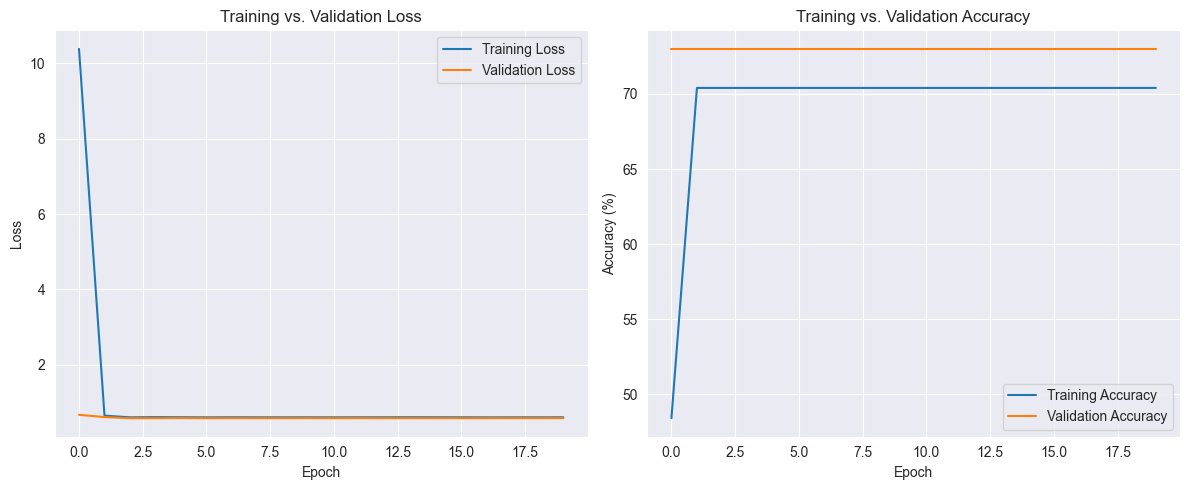

In [31]:
model = CNN().to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4) # L2 regularization

train_losses, train_accuracies, validation_losses, validation_accuracies = train_and_validate(model, train_loader, test_loader, criterion, optimizer, epochs, device)
plot_metrics(train_losses, train_accuracies, validation_losses, validation_accuracies)

In [32]:
# Calculate and print the number of parameters per layer
total_param_num = 0
for name, param in cnn_model.named_parameters():
    print(f"Layer: {name}, Parameters: {param.numel()}")
    total_param_num += param.numel()

print(f"\nTotal number of parameters: {total_param_num}")

Layer: conv_layer.0.weight, Parameters: 864
Layer: conv_layer.0.bias, Parameters: 32
Layer: conv_layer.1.weight, Parameters: 32
Layer: conv_layer.1.bias, Parameters: 32
Layer: conv_layer.3.weight, Parameters: 9216
Layer: conv_layer.3.bias, Parameters: 32
Layer: conv_layer.6.weight, Parameters: 18432
Layer: conv_layer.6.bias, Parameters: 64
Layer: conv_layer.7.weight, Parameters: 64
Layer: conv_layer.7.bias, Parameters: 64
Layer: conv_layer.9.weight, Parameters: 36864
Layer: conv_layer.9.bias, Parameters: 64
Layer: fc_layer.1.weight, Parameters: 4718592
Layer: fc_layer.1.bias, Parameters: 512
Layer: fc_layer.3.weight, Parameters: 1024
Layer: fc_layer.3.bias, Parameters: 2

Total number of parameters: 4785890


Fine tunning ResNet

In [33]:
class FineTuneResNet(nn.Module):
    def __init__(self, num_classes=10, dropout_rate=0.2):
        super(FineTuneResNet, self).__init__()
        # Load a pre-trained ResNet
        self.resnet = models.resnet18(pretrained=True)
        
        # Remove the final fully connected layer
        num_ftrs = self.resnet.fc.in_features
        self.resnet.fc = nn.Identity()  # Remove the last fully connected layer
        
        # Define the new fully connected layer
        self.fc_layer = nn.Sequential(
            nn.Dropout(p=dropout_rate),
            nn.Linear(num_ftrs, 128),
            nn.ReLU(inplace=True),
            nn.Linear(128, num_classes)
        )
        
    def forward(self, x):
        # Forward through the ResNet layers
        x = self.resnet(x)
        # Forward through the new fully connected layer
        x = self.fc_layer(x)
        return x

finetuned_resnet = FineTuneResNet().to(device)
print(finetuned_resnet)

FineTuneResNet(
  (resnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, tra

C:\Users\User\PycharmProjects\DLProject\venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\User\PycharmProjects\DLProject\venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [34]:
# Calculate and print the number of parameters per layer
total_param_num = 0
for name, param in finetuned_resnet.named_parameters():
    print(f"Layer: {name}, Parameters: {param.numel()}")
    total_param_num += param.numel()

print(f"\nTotal number of parameters: {total_param_num}")

Layer: resnet.conv1.weight, Parameters: 9408
Layer: resnet.bn1.weight, Parameters: 64
Layer: resnet.bn1.bias, Parameters: 64
Layer: resnet.layer1.0.conv1.weight, Parameters: 36864
Layer: resnet.layer1.0.bn1.weight, Parameters: 64
Layer: resnet.layer1.0.bn1.bias, Parameters: 64
Layer: resnet.layer1.0.conv2.weight, Parameters: 36864
Layer: resnet.layer1.0.bn2.weight, Parameters: 64
Layer: resnet.layer1.0.bn2.bias, Parameters: 64
Layer: resnet.layer1.1.conv1.weight, Parameters: 36864
Layer: resnet.layer1.1.bn1.weight, Parameters: 64
Layer: resnet.layer1.1.bn1.bias, Parameters: 64
Layer: resnet.layer1.1.conv2.weight, Parameters: 36864
Layer: resnet.layer1.1.bn2.weight, Parameters: 64
Layer: resnet.layer1.1.bn2.bias, Parameters: 64
Layer: resnet.layer2.0.conv1.weight, Parameters: 73728
Layer: resnet.layer2.0.bn1.weight, Parameters: 128
Layer: resnet.layer2.0.bn1.bias, Parameters: 128
Layer: resnet.layer2.0.conv2.weight, Parameters: 147456
Layer: resnet.layer2.0.bn2.weight, Parameters: 128
L

C:\Users\User\PycharmProjects\DLProject\venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\User\PycharmProjects\DLProject\venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/20], Training Loss: 1.0477, Training Accuracy: 62.20%, Validation Loss: 1267.8590, Validation Accuracy: 73.00%
Epoch [2/20], Training Loss: 0.7742, Training Accuracy: 68.00%, Validation Loss: 62.1728, Validation Accuracy: 76.00%
Epoch [3/20], Training Loss: 0.5433, Training Accuracy: 74.20%, Validation Loss: 1.1560, Validation Accuracy: 72.00%
Epoch [4/20], Training Loss: 0.4913, Training Accuracy: 78.60%, Validation Loss: 3.2433, Validation Accuracy: 78.00%
Epoch [5/20], Training Loss: 0.4545, Training Accuracy: 80.80%, Validation Loss: 0.4781, Validation Accuracy: 80.50%
Epoch [6/20], Training Loss: 0.4714, Training Accuracy: 82.00%, Validation Loss: 0.4730, Validation Accuracy: 79.50%
Epoch [7/20], Training Loss: 0.4161, Training Accuracy: 82.80%, Validation Loss: 0.4994, Validation Accuracy: 80.00%
Epoch [8/20], Training Loss: 0.4739, Training Accuracy: 80.80%, Validation Loss: 0.5081, Validation Accuracy: 72.00%
Epoch [9/20], Training Loss: 0.5053, Training Accuracy: 76.6

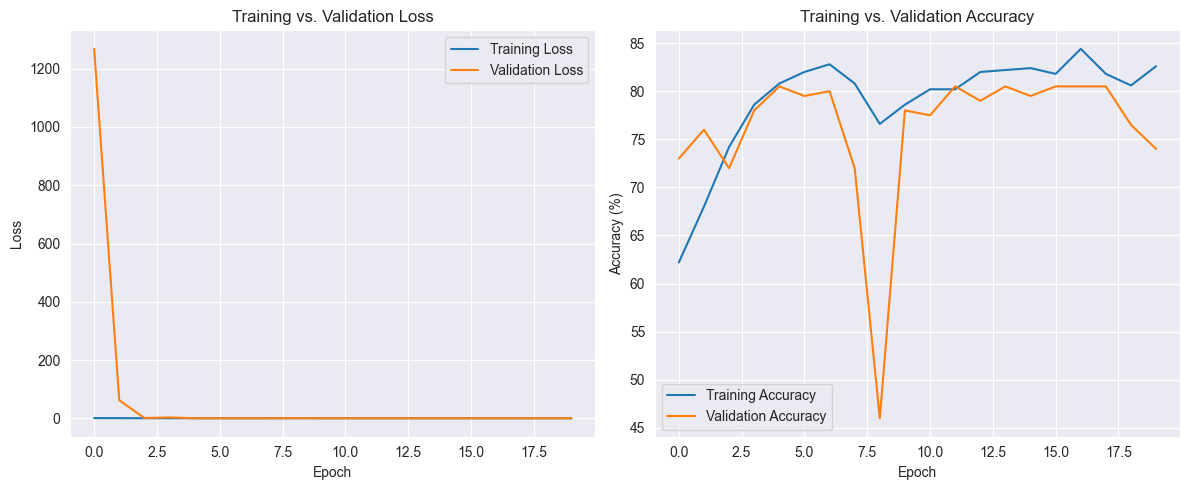

In [35]:
model = FineTuneResNet().to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4) # L2 regularization

train_losses, train_accuracies, validation_losses, validation_accuracies = train_and_validate(model, train_loader, test_loader, criterion, optimizer, epochs, device)
plot_metrics(train_losses, train_accuracies, validation_losses, validation_accuracies)

Data Augmentation

In [36]:
# Enhanced augmentation + normalization for training
train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4), # Randomly crop the images and pad the borders
    transforms.RandomHorizontalFlip(),  # Randomly flip the images on the horizontal axis
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)  # Normalize images
])

# Only normalization for testing, no augmentation
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)  # Normalize images
])

# CIFAR10 datasets with transformations
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=test_transform)
full_train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=train_transform)

# Reducing the dataset size
indices = list(range(train_dataset_size))
train_dataset = Subset(full_train_dataset, indices)

# Data loaders
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)

print(f"Full train set size: {len(full_train_dataset)} - Reduced train set size: {len(train_dataset)} - Test set size: {len(test_dataset)}")

Files already downloaded and verified
Files already downloaded and verified
Full train set size: 50000 - Reduced train set size: 500 - Test set size: 10000


C:\Users\User\PycharmProjects\DLProject\venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\User\PycharmProjects\DLProject\venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/20], Training Loss: 2.7802, Training Accuracy: 10.80%, Validation Loss: 130.2927, Validation Accuracy: 10.00%
Epoch [2/20], Training Loss: 2.2992, Training Accuracy: 11.60%, Validation Loss: 2.3096, Validation Accuracy: 11.17%
Epoch [3/20], Training Loss: 2.2956, Training Accuracy: 11.40%, Validation Loss: 2.3027, Validation Accuracy: 12.21%
Epoch [4/20], Training Loss: 2.2872, Training Accuracy: 14.40%, Validation Loss: 2.2955, Validation Accuracy: 12.31%
Epoch [5/20], Training Loss: 2.2617, Training Accuracy: 16.00%, Validation Loss: 2.2419, Validation Accuracy: 14.48%
Epoch [6/20], Training Loss: 2.1866, Training Accuracy: 15.80%, Validation Loss: 2.2040, Validation Accuracy: 15.17%
Epoch [7/20], Training Loss: 2.1583, Training Accuracy: 17.80%, Validation Loss: 2.1698, Validation Accuracy: 16.41%
Epoch [8/20], Training Loss: 2.1477, Training Accuracy: 16.20%, Validation Loss: 2.1330, Validation Accuracy: 16.57%
Epoch [9/20], Training Loss: 2.1159, Training Accuracy: 19.20%

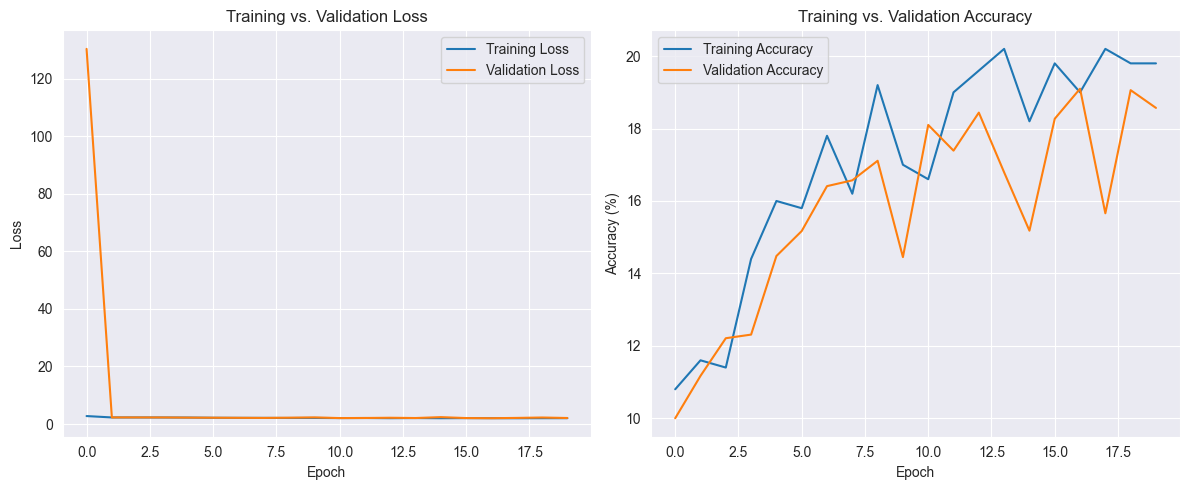

In [37]:
model = FineTuneResNet().to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4) # L2 regularization

train_losses, train_accuracies, validation_losses, validation_accuracies = train_and_validate(model, train_loader, test_loader, criterion, optimizer, epochs, device)
plot_metrics(train_losses, train_accuracies, validation_losses, validation_accuracies)